# Satellite Imagery Patch Extractor


**Notes**:
- This example uses [Sentinel-2 Level-2A data](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). The techniques used here apply equally well to other remote-sensing datasets.
- If you're running this on the [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute), make sure to choose the **GPU - PyTorch** profile when presented with the form to choose your environment.

In [44]:
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gpd
import dask_geopandas
# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc
from dask.distributed import Client, progress

In [2]:
from typing import Any, Optional, Union, TYPE_CHECKING
# if TYPE_CHECKING:
import numpy.typing as npt

Coordinates = tuple[float, float]
Patch = npt.NDArray[np.float32]


In [3]:
Coordinates

tuple[float, float]

In [49]:
## Set Resolution for Sentinel-2 images
sentinel2_metadata = {
    'visual' : {'resolution' : 10, 'bits' : 16},
    'B08' : {'resolution' : 10, 'bits' : 16},
    'crs' : 'epsg:4326'
}

import dask_gateway

## This will be used for both training and testing in different configurations:
# Train : centroids are always the centroid of the grids
# Test : centroids will be the points at which we will be sampling to test
class SIPatchExtractor(object):
    """
    Handles the loading and extraction of an environmental tensor from multiple rasters given GPS coordinates.
    """
    
#     global cluster_options, cluster, client, gateway
    
    dask_geopandas_partitions = 250
    
#     def check_for_existing_clusters(self):
#         if len(gateway.list_clusters()) == 0:
#             return False   
#         return True

#     #max is 113
#     def setup_dask_cluster(self, max=50, mem=16, adapt=True):
        
#         cluster_options["worker_memory"] = mem

#         if self.check_for_existing_clusters():
#             print ("Clusters already exist, latching onto the first one")

#             clusters = gateway.list_clusters()
#             cluster = gateway.connect(clusters[0].name)

#             client = cluster.get_client()

#         else:
#             print("Setting up new cluster..")
#             cluster = gateway.new_cluster(cluster_options, shutdown_on_close=False)
#             print("Getting client..")
#             client = cluster.get_client()
#             if adapt:
#                 cluster.adapt(minimum=2, maximum=max)
#             else:
#                 cluster.scale(max)



#         print(client)
#         print(cluster.dashboard_link)
#         return cluster, client


#     def shutdown_all_clusters(self):

#         clusters = gateway.list_clusters()
#         if clusters is not None:
#             for c in clusters:
#                 cluster = gateway.connect(c.name)
#                 cluster.shutdown()
#                 print (cluster)


#     def dashboard(self):
#         return cluster.dashboard_link



    
    def _query(self, points):
        """
        Find a STAC item for points in the `points` DataFrame

        Parameters
        ----------
        points : geopandas.GeoDataFrame
            A GeoDataFrame

        Returns
        -------
        geopandas.GeoDataFrame
            A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
            item that covers each point.
        """
        intersects = shapely.geometry.mapping(points.unary_union.convex_hull) #TODO replace with rectangular geometry

        search_start = "2018-01-01"
        search_end = "2019-12-31"
        catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                            modifier=pc.sign_inplace)
        # catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

        # The time frame in which we search for non-cloudy imagery
        search = catalog.search(
            collections=["sentinel-2-l2a"],
            intersects=intersects,
            datetime=[search_start, search_end],
            query={"eo:cloud_cover": {"lt": 10}},
            limit=500,
        )
        ic = search.get_all_items_as_dict()

        features = ic["features"]
        features_d = {item["id"]: item for item in features}

        data = {
            "eo:cloud_cover": [],
            "geometry": [],
        }

        index = []

        for item in features:
            data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
            data["geometry"].append(shapely.geometry.shape(item["geometry"]))
            index.append(item["id"])

        items = gpd.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
            "eo:cloud_cover"
        )
        point_list = points.geometry.tolist()

        point_items = []
        for point in point_list:
            covered_by = items[items.covers(point)]
            if len(covered_by):
                point_items.append(features_d[covered_by.index[0]])
            else:
                # There weren't any scenes matching our conditions for this point (too cloudy)
                point_items.append(None)

        return points.assign(stac_item=point_items)



    def __init__(self, centroids: gpd.GeoDataFrame, side_length_m:int=1000, side_px:int=64):
        """Constructor

        Parameters
        ----------
        centroids : a geopandas frame with 4 columns:
            grid_id, lons, lats, geometry (of the centroid)
            In Train mode, these coordinates are centroids,
            In Test mode, these would be the coordinates of observations
            
        side_length_m : integer
            Size in meters (side_length_m x side_length_m) of the patches to extract around each location.
            
        side_px : integer
            Size in pixels of the image patch output
        """
        assert(len(centroids.columns) == 4)
        
        self.side_length = side_length_m
        self.side_px = side_px
        self.points = np.array(centroids[['lon','lat']])
        self.centroids = centroids.copy()

        
        #Setup a cluster for compute
        # print("Setting up cluster for compute...")
#         cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
#         client = cluster.get_client()

#         cluster.adapt(minimum=4, maximum=100)
#         print(cluster.dashboard_link)
        # self.setup_dask_cluster()
        
 
        print("Organizing grid centroids according to Hilbert distance...")
        ddf = dask_geopandas.from_geopandas(self.centroids, npartitions=1)
        hd = ddf.hilbert_distance().compute()
        self.centroids["hd"] = hd
        self.centroids = self.centroids.sort_values("hd")
        dgdf = dask_geopandas.from_geopandas(self.centroids, npartitions=self.dask_geopandas_partitions, sort=False)
        
        
        print("Get the URLs of all the Sentinel-2 images to extract from ...")

        # with Client(n_workers=16) as client:
        #     print(client.dashboard_link)
        #     meta = dgdf._meta.assign(stac_item=[])
        #     df2 = dgdf.map_partitions(self._query, meta=meta).compute()
            
        from dask_gateway import GatewayCluster
        cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
        client = cluster.get_client()
        cluster.adapt(minimum=4, maximum=24)
        print(cluster.dashboard_link)   
        meta = dgdf._meta.assign(stac_item=[])
        df2 = dgdf.map_partitions(self._query, meta=meta).compute()
        
        
        self.data = df2.dropna(subset=["stac_item"])
        #Save it as a tuple -> (RGB,NIR)
        self.data['urls'] = [(item["assets"]["visual"]["href"], item["assets"]["B08"]["href"]) for item in self.data.stac_item.tolist()]
        
        print("{} URLs acquired. Shutting Down Cluster".format(len(self.data)))
        cluster.close()
        
        #Close the cluster
        # print("Closing dask cluster...")
        # cluster.close()
        
    

    def clean(self) -> None:
        """Remove all rasters from the extractor."""
        # self.rasters_fr = []
        self.data = None
        # self.matching_urls = []


    def __repr__(self) -> str:
        return str(self)


    def __getitem__(self, idx:int=-1): #, coordinates: Coordinates) -> npt.NDArray[np.float32]:
        """Extracts the patches around the given GPS coordinates for all the previously loaded rasters.

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)
        idx : int containing the grid id of the patch in question
            **Used only in training mode**
            **-1 for test mode**
        
        Returns
        -------
        patch : 3d array of floats, [n_rasters, size, size]
            Extracted patches around the given coordinates.
        """


        if (idx > -1):
            lon, lat = self.data.lon[idx], self.data.lat[idx]
            fn_RGB = self.data.urls[idx][0]
            fn_NIR = self.data.urls[idx][1]
        ##TODO
        else: #Test mode where a gps coordinates are entered (prob not required)
            idx = 0 # do something dumb for now
            
            
            
        mask_geom = None

        if fn_RGB is None or fn_NIR is None:
            return None
        else:
            point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

            #RGB
            with rasterio.Env():
                with rasterio.open(fn_RGB, "r") as f:
                    point_geom = rasterio.warp.transform_geom(
                        "epsg:4326", f.crs.to_string(), point_geom)
                    #Convert the point to a shape
                    point_shape = shapely.geometry.shape(point_geom)
                    #Create a square out of it with side_length = buffer*2
                    mask_shape = point_shape.buffer(self.side_length/2).envelope
                    mask_geom = shapely.geometry.mapping(mask_shape)
                    
                    #crop to the aoi (mask)
                    try:
                        image_rgb, _ = rasterio.mask.mask(
                            f, [mask_geom], crop=True
                        )
                    except ValueError as e:
                        if "Input shapes do not overlap raster." in str(e):
                            return None
                        
            #NIR
            with rasterio.Env():
                with rasterio.open(fn_NIR, "r") as f:
                    
                    #crop to the aoi (mask)
                    try:
                        image_nir, _ = rasterio.mask.mask(
                            f, [mask_geom], crop=True
                        )
                    except ValueError as e:
                        if "Input shapes do not overlap raster." in str(e):
                            return None
                        
            #Combine the (3,W,H) and (1,W,H) tensors into (4,W,H)
            out_image = np.vstack((image_rgb, image_nir))
            # print(out_image.max(), out_image.shape)
            out_image = out_image / 255.0

            out_image = torch.from_numpy(out_image).float()
            out_image = F.resize(out_image, (self.side_px, self.side_px))
            # print(out_image.shape)
            assert(out_image.shape )
            
            return out_image

    def __len__(self) -> int:
        """Number of variables/rasters loaded.

        Returns
        -------
        n_rasters : integer
            Number of loaded rasters
        """
        return len(self.data)

    def plot(
        self,
        coordinates: Coordinates,
        return_fig: bool = False,
        n_cols: int = 5,
        fig: Optional[plt.Figure] = None,
        resolution: float = 1.0,
    ) -> Optional[plt.Figure]:
        """Plot an environmental tensor (only works if size > 1)

        Parameters
        ----------
        coordinates : tuple containing two floats
            GPS coordinates (latitude, longitude)
        return_fig : boolean
            If True, returns the created plt.Figure object
        n_cols : integer
            Number of columns to use
        fig : plt.Figure or None
            If not None, use the given plt.Figure object instead of creating a new one
        resolution : float
            Resolution of the created figure

        Returns
        -------
        fig : plt.Figure
            If return_fig is True, the used plt.Figure object
        """
        # if self.size <= 1:
        #     raise ValueError("Plot works only for tensors: size must be > 1")

        rasters = self._get_rasters_list(coordinates)

        # Metadata are the name of the variables and the bounding boxes in latitude-longitude coordinates
        metadata = [
            (
                raster.name,
                [
                    coordinates[1] - (self.size // 2) * raster.dataset.res[0],
                    coordinates[1] + (self.size // 2) * raster.dataset.res[0],
                    coordinates[0] - (self.size // 2) * raster.dataset.res[1],
                    coordinates[0] + (self.size // 2) * raster.dataset.res[1],
                ],
            )
            for raster in rasters
        ]

        # Extracts the patch
        patch = self[coordinates]

        # Computing number of rows and columns
        n_rows = (patch.shape[0] + (n_cols - 1)) // n_cols

        if fig is None:
            fig = plt.figure(
                figsize=(n_cols * 6.4 * resolution, n_rows * 4.8 * resolution)
            )

        axes = fig.subplots(n_rows, n_cols)
        axes = axes.ravel()

        for i, (ax, k) in enumerate(zip(axes, metadata)):
            p = np.squeeze(patch[i])
            im = ax.imshow(p, extent=k[1], aspect="equal", interpolation="none")

            ax.set_title(k[0], fontsize=20)
            fig.colorbar(im, ax=ax)

        for ax in axes[len(metadata) :]:
            ax.axis("off")

        fig.tight_layout()

        if return_fig:
            return fig

        return None

## 1. Read Sample KDE Files

In [5]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '.'
LABEL_PATH = '../data/labels/ca/'


In [6]:
BUCKET_NAME = 'datasets-sdm'
folder = 'kde/ca'
filename = 'geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl'

s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [7]:
kde_gdf = pd.read_pickle(s3_read_path)
kde_gdf.head()

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate a list of centroids -> GPD frame

In [8]:
#Convert to equal area projection and back to avoid CRS issues with calculating centroid:
# df1.to_crs('+proj=cea').centroid.to_crs(df1.crs)

c = kde_gdf.to_crs('+proj=cea').centroid.to_crs(kde_gdf.crs)

centroids = pd.DataFrame()
centroids['grid_id'] = kde_gdf.grid_id
centroids['lon'] = c.x.values
centroids['lat'] = c.y.values
centroids = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['lon'], centroids['lat']))

# kde_gdf_test['lon'] = kde_gdf_test.to_crs('+proj=cea').centroid.to_crs(kde_gdf_test.crs).y.values
centroids.head()

,grid_id,lon,lat,geometry
0,0,-124.390558,40.255879,POINT (-124.39056 40.25588)
1,1,-124.390558,40.305879,POINT (-124.39056 40.30588)
2,2,-124.390558,40.355879,POINT (-124.39056 40.35588)
3,3,-124.390558,40.405879,POINT (-124.39056 40.40588)
4,4,-124.390558,40.455879,POINT (-124.39056 40.45588)


<AxesSubplot:>

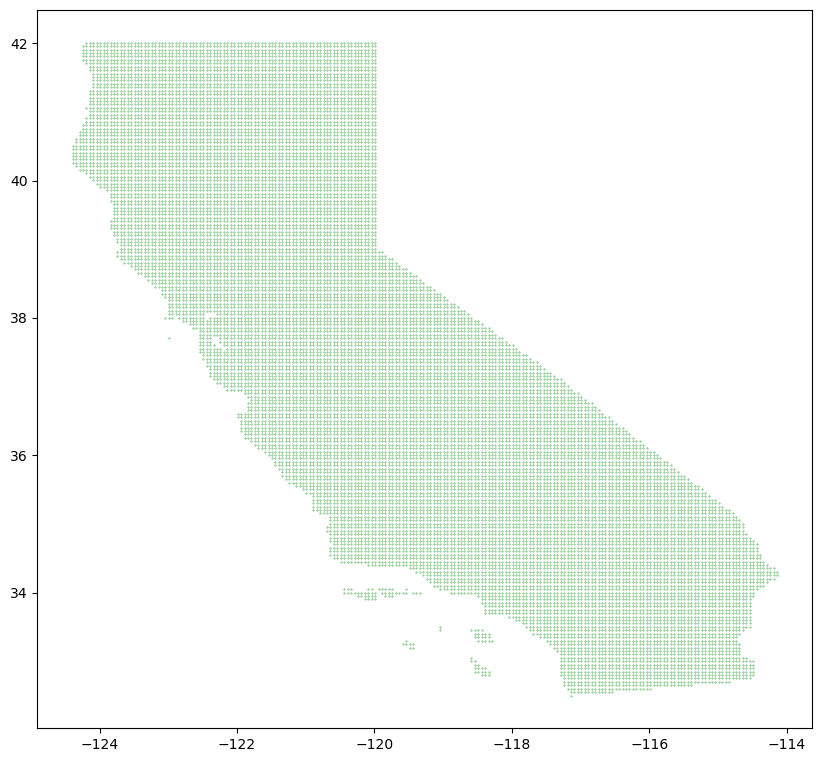

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

centroids.plot(edgecolor = 'tab:green', alpha=1, ax=ax, markersize=0.1)

In [61]:
# points = 
# xys = np.vstack([kde_gdf.geometry.centroid.x, kde_gdf.geometry.centroid.y]).T
# xys.shape
# points = pd.DataFrame(xys, columns=['lon', 'lat'], index=kde_gdf.grid_id)

# points = np.array(centroids[['lon','lat']])

# lon, lat = points[2]
# type(points), lon, lat

(numpy.ndarray, -124.39055786132813, 40.35587922005108)

## Subset it

In [9]:
kde_gdf_test = centroids[1000:1200]
kde_gdf_test.head()
# points = points[0:200]

,grid_id,lon,lat,geometry
1000,1000,-123.340558,41.105879,POINT (-123.34056 41.10588)
1001,1001,-123.340558,41.155879,POINT (-123.34056 41.15588)
1002,1002,-123.340558,41.205879,POINT (-123.34056 41.20588)
1003,1003,-123.340558,41.255879,POINT (-123.34056 41.25588)
1004,1004,-123.340558,41.305879,POINT (-123.34056 41.30588)


# Extract features from the imagery around each point

In [50]:
kde_gdf_test.columns, kde_gdf_test.head()

(Index(['grid_id', 'lon', 'lat', 'geometry'], dtype='object'),
       grid_id         lon        lat                     geometry
 1000     1000 -123.340558  41.105879  POINT (-123.34056 41.10588)
 1001     1001 -123.340558  41.155879  POINT (-123.34056 41.15588)
 1002     1002 -123.340558  41.205879  POINT (-123.34056 41.20588)
 1003     1003 -123.340558  41.255879  POINT (-123.34056 41.25588)
 1004     1004 -123.340558  41.305879  POINT (-123.34056 41.30588))

In [51]:
Sentinel_Images = SIPatchExtractor(kde_gdf_test, side_length_m=5000, side_px=64)

Organizing grid centroids according to Hilbert distance...
Get the URLs of all the Sentinel-2 images to extract from ...
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b2aa27851f114f41abae51af9e5440ec/status
200 URLs acquired. Shutting Down Cluster


In [52]:
len(Sentinel_Images)

200

In [53]:
Sentinel_Images.data.head()

,grid_id,lon,lat,geometry,hd,stac_item,urls
1022,1022,-123.290558,38.705879,POINT (-123.29056 38.70588),303929732,{'id': 'S2B_MSIL2A_20191025T190449_R013_T10SDH...,(https://sentinel2l2a01.blob.core.windows.net/...
1023,1023,-123.290558,38.755879,POINT (-123.29056 38.75588),304248605,{'id': 'S2B_MSIL2A_20191025T190449_R013_T10SDH...,(https://sentinel2l2a01.blob.core.windows.net/...
1025,1025,-123.290558,38.855879,POINT (-123.29056 38.85588),308398291,{'id': 'S2B_MSIL2A_20191025T190449_R013_T10SDJ...,(https://sentinel2l2a01.blob.core.windows.net/...
1024,1024,-123.290558,38.805879,POINT (-123.29056 38.80588),309894856,{'id': 'S2B_MSIL2A_20191025T190449_R013_T10SDH...,(https://sentinel2l2a01.blob.core.windows.net/...
1021,1021,-123.290558,38.655879,POINT (-123.29056 38.65588),323823433,{'id': 'S2B_MSIL2A_20191025T190449_R013_T10SDH...,(https://sentinel2l2a01.blob.core.windows.net/...


In [54]:
Sentinel_Images[1000].shape

torch.Size([4, 64, 64])

In [55]:
Sentinel_Images.data.urls[1000][0]
Sentinel_Images.data.lon[1000], Sentinel_Images.data.lat[1000]

(-123.34055786132818, 41.1058790963565)

## Display some images for sanity checking

In [39]:
import torchvision.transforms as T
from PIL import Image
 

1076


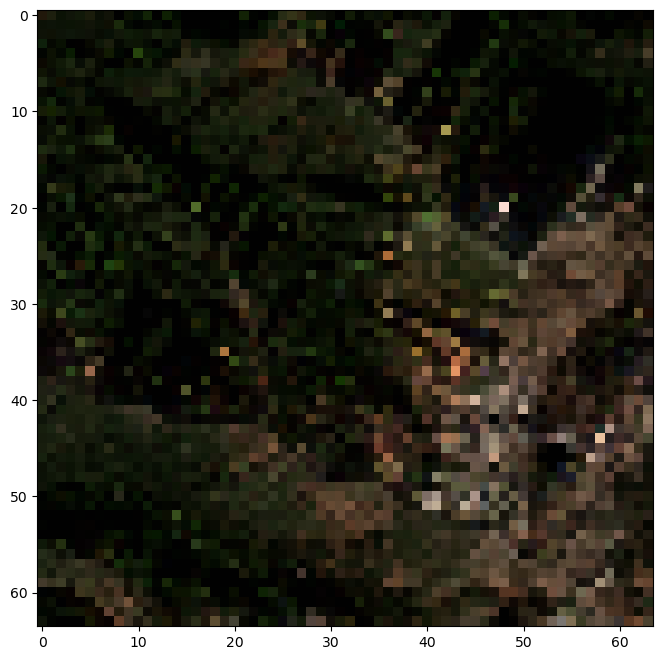

In [56]:
index = np.random.randint(1000, 1200)
print(index)

tensor = Sentinel_Images[index]
transform = T.ToPILImage()
image = transform(tensor[0:3,:,:])
# image = transform(tensor)
plt.figure(figsize=(8,8))
# plt.title('Centered at {:.2f},{:.2f}'.format(dataset.get_point(0)[0],dataset.get_point(0)[1]))
plt.imshow(image)

In [72]:
def display_dataset(
    dataset, 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):
    
    # define a transform to convert a tensor to PIL image
    # tensors = dataloader.dataset
    transform = T.ToPILImage()


    height = max(height, int(len(dataset)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, tensor in enumerate(dataset):
        
        if i>max_images:
            return
        
        if tensor.shape[0] > 3: #More than RGB,we will assume that the first 3 channels are RGB
            image = transform(tensor[0:3,:,:])
        else:
            image = transform(tensor)
            
        plt.subplot(int(len(dataset) / columns + 1), columns, i + 1)
        plt.title('Centered at {:.2f},{:.2f}'.format(dataset.get_point(i)[0],dataset.get_point(i)[1]))
        plt.imshow(image)

    